# Part A  Data preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sentiment = pd.read_csv("fear_greed_index.csv")
trader = pd.read_csv("historical_data.csv")

In [8]:
sentiment.columns = sentiment.columns.str.strip()
trader.columns = trader.columns.str.strip()

print(sentiment.columns)
print(trader.columns)



Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [13]:
sentiment['Date'] = pd.to_datetime(sentiment.iloc[:,0]).dt.date
time_column = None
for col in trader.columns:
    if 'time' in col.lower():
        time_column = col
        break

# convert datetime
trader['DateTime'] = pd.to_datetime(trader[time_column], dayfirst=True)
trader['Date'] = trader['DateTime'].dt.date


In [14]:
print("Sentiment Shape:", sentiment.shape)
print("Trader Shape:", trader.shape)

print("\nMissing values:")
print(trader.isnull().sum())

print("\nDuplicates:", trader.duplicated().sum())



Sentiment Shape: (2644, 5)
Trader Shape: (211224, 18)

Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
DateTime            0
Date                0
dtype: int64

Duplicates: 0


In [15]:
merged = trader.merge(
    sentiment[['Date','classification']],
    on="Date",
    how="left"
)

merged.head()



,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,DateTime,Date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,NaN


In [16]:
daily_pnl = merged.groupby(['Account','Date'])['Closed PnL'].sum().reset_index()


In [17]:

sentiment.columns = sentiment.columns.str.strip()
trader.columns = trader.columns.str.strip()

print("Sentiment columns:", sentiment.columns)
print("Trader columns:", trader.columns)



Sentiment columns: Index(['timestamp', 'value', 'classification', 'date', 'Date'], dtype='object')
Trader columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'DateTime', 'Date'],
      dtype='object')


In [18]:
merged['win'] = (merged['Closed PnL'] > 0).astype(int)

win_rate = merged.groupby('Account')['win'].mean().reset_index()


In [19]:
avg_size = merged.groupby('Account')['Size USD'].mean().reset_index()


In [20]:
merged['Size Tokens'].describe()


count    2.112240e+05
mean     4.623365e+03
std      1.042729e+05
min      8.740000e-07
25%      2.940000e+00
50%      3.200000e+01
75%      1.879025e+02
max      1.582244e+07
Name: Size Tokens, dtype: float64

In [21]:
trades_per_day = merged.groupby('Date').size().reset_index(name='trade_count')


In [22]:
merged['position'] = merged['Side'].apply(
    lambda x: 'Long' if str(x).lower()=='buy' else 'Short'
)

long_short = merged.groupby(['Date','position']).size().unstack(fill_value=0)

long_short['ratio'] = long_short['Long'] / (long_short['Short']+1)

# Part B Part B — Analysis 

In [24]:
merged.columns = merged.columns.str.strip().str.lower()

print(merged.columns)


Index(['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side',
       'timestamp ist', 'start position', 'direction', 'closed pnl',
       'transaction hash', 'order id', 'crossed', 'fee', 'trade id',
       'timestamp', 'datetime', 'date', 'classification', 'win', 'position'],
      dtype='object')


Empty DataFrame
Columns: [classification, closed pnl]
Index: []


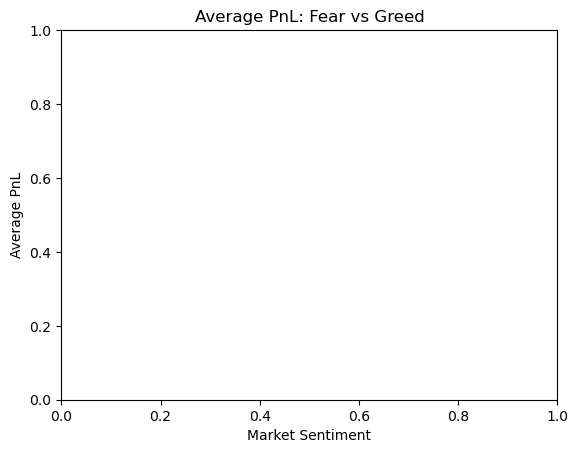

In [25]:

pnl_sentiment = merged.groupby('classification')['closed pnl'].mean().reset_index()

print(pnl_sentiment)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='classification', y='closed pnl', data=pnl_sentiment)
plt.title("Average PnL: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.show()


Empty DataFrame
Columns: [classification, win]
Index: []


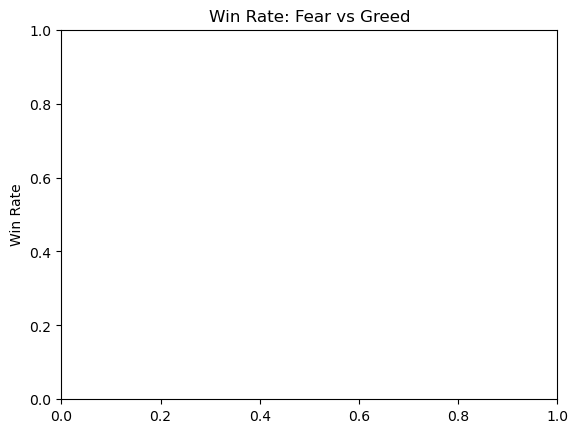

In [27]:
merged['win'] = (merged['closed pnl'] > 0).astype(int)
winrate_sentiment = merged.groupby('classification')['win'].mean().reset_index()

print(winrate_sentiment)
sns.barplot(x='classification', y='win', data=winrate_sentiment)
plt.title("Win Rate: Fear vs Greed")
plt.ylabel("Win Rate")
plt.show()


Empty DataFrame
Columns: [classification, Trade ID]
Index: []


IndexError: index 0 is out of bounds for axis 0 with size 0

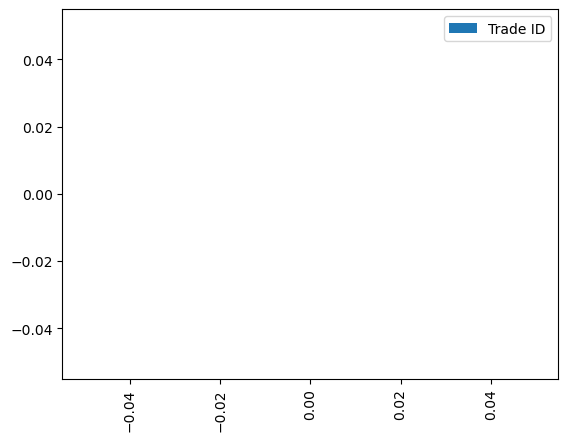

In [30]:
trade_freq = merged.groupby('classification').size().reset_index(name='Trade ID')

print(trade_freq)

trade_freq.plot(kind='bar', x='classification', y='Trade ID')
plt.title("Number of Trades: Fear vs Greed")
plt.show()


Empty DataFrame
Columns: [classification, size usd]
Index: []


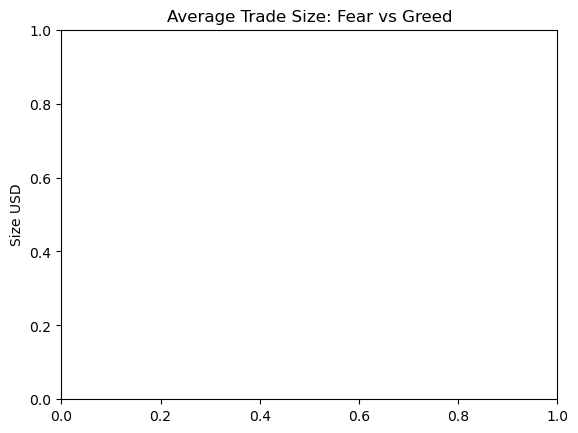

In [44]:
avg_size_sentiment = merged.groupby('classification')['size usd'].mean().reset_index()

print(avg_size_sentiment)

sns.barplot(x='classification', y='size usd', data=avg_size_sentiment)
plt.title("Average Trade Size: Fear vs Greed")
plt.ylabel("Size USD")
plt.show()


In [4]:
merged['position'] = merged['Side'].apply(
    lambda x: 'Long' if str(x).lower() == 'buy' else 'Short'
)

position_sentiment = merged.groupby(['classification','position']).size().unstack()

print(position_sentiment)

position_sentiment.plot(kind='bar', stacked=True)
plt.title("Long vs Short by Sentiment")
plt.show()


NameError: name 'merged' is not defined

In [ ]:
# Count trades per trader
trade_count = merged.groupby('account').size().reset_index(name='trade_count')

# classify traders
median_trades = trade_count['trade_count'].median()

trade_count['trader_type'] = trade_count['trade_count'].apply(
    lambda x: 'Frequent' if x > median_trades else 'Infrequent'
)

# merge back
merged = merged.merge(trade_count[['account','trader_type']], on='account')

# compare pnl
segment_pnl = merged.groupby('trader_type')['closed pnl'].mean().reset_index()

print(segment_pnl)

sns.barplot(x='trader_type', y='closed pnl', data=segment_pnl)
plt.title("PnL: Frequent vs Infrequent Traders")
plt.show()


In [2]:
# total pnl per trader
trader_pnl = merged.groupby('account')['closed pnl'].sum().reset_index()

trader_pnl['type'] = trader_pnl['closed pnl'].apply(
    lambda x: 'Winner' if x > 0 else 'Loser'
)

# merge back
merged = merged.merge(trader_pnl[['account','type']], on='account')

# compare
winner_analysis = merged.groupby('type')['closed pnl'].mean().reset_index()

print(winner_analysis)

sns.barplot(x='type', y='closed pnl', data=winner_analysis)
plt.title("Average Trade PnL: Winners vs Losers")
plt.show()


NameError: name 'merged' is not defined

In [3]:
daily_sentiment_pnl = merged.groupby(['date','classification'])['closed pnl'].sum().reset_index()

sns.lineplot(x='date', y='closed pnl', hue='classification', data=daily_sentiment_pnl)
plt.title("Daily PnL Trend: Fear vs Greed")
plt.xticks(rotation=45)
plt.show()


NameError: name 'merged' is not defined

# part C Actionable output

In [36]:
import pandas as pd
import matplotlib.pyplot as plt


sentiment = pd.read_csv("historical_data.csv")
trader = pd.read_csv("fear_greed_index.csv")

sentiment.columns = sentiment.columns.str.strip().str.lower()
trader.columns = trader.columns.str.strip().str.lower()

trader.rename(columns={
    "closed pnl": "closed_pnl",
    "size usd": "size_usd"
}, inplace=True)


sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
trader['date'] = pd.to_datetime(trader['timestamp']).dt.date

merged = pd.merge(
    trader,
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

print("Merged Shape:", merged.shape)

if merged.empty:
    print("Merge failed. Check date formats.")
else:

    pnl_analysis = merged.groupby('classification')['closed_pnl'].sum()
    print("\nTotal PnL by Sentiment:")
    print(pnl_analysis)

    avg_pnl = merged.groupby('classification')['closed_pnl'].mean()
    print("\nAverage PnL per Trade:")
    print(avg_pnl)
    trade_count = merged.groupby('classification').size()
    print("\nTrade Count:")
    print(trade_count)

    merged['win'] = merged['closed_pnl'] > 0
    win_rate = merged.groupby('classification')['win'].mean() * 100
    print("\nWin Rate (%):")
    print(win_rate)
    """
    Strategy Idea:
    - During FEAR → Take LONG positions
    - During GREED → Take SHORT positions
    """

    merged['strategy_signal'] = None

    merged.loc[
        (merged['classification'] == 'Fear') & 
        (merged['side'] == 'BUY'),
        'strategy_signal'
    ] = 'Correct'

    merged.loc[
        (merged['classification'] == 'Greed') & 
        (merged['side'] == 'SELL'),
        'strategy_signal'
    ] = 'Correct'

    merged['strategy_win'] = merged['strategy_signal'] == 'Correct'

    strategy_accuracy = merged['strategy_win'].mean() * 100
    print("\nStrategy Accuracy (%):", strategy_accuracy)

    pnl_analysis.plot(kind='bar')
    plt.title("Total PnL During Fear vs Greed")
    plt.ylabel("Total PnL")
    plt.show()

    win_rate.plot(kind='bar')
    plt.title("Win Rate During Fear vs Greed")
    plt.ylabel("Win Rate %")
    plt.show()


KeyError: 'date'